
# Uber Fare Prediction — Cleaned Practical Notebook

**Tasks covered:**  
1. Pre-process the dataset (datetime parsing, dtype fixes).  
2. Identify outliers (IQR method) and optionally remove them.  
3. Check correlations between features and target.  
4. Implement Linear Regression and Random Forest Regression.  
5. Evaluate models (R², RMSE, MAE) and compare results.




In [ ]:

# Basic imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error





In [ ]:

# Load data (adjust path if needed)
df = pd.read_csv("uber.csv")
df.head()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [ ]:

# Inspect columns and basic info
display(df.info())
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


None

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [ ]:

# Drop obvious useless columns

df.drop(columns=['Unnamed: 0', 'key'], inplace=True)
print("After dropping cols, shape:", df.shape)


After dropping cols, shape: (200000, 7)


In [ ]:

# Parse pickup_datetime to datetime and extract month & hour as integer types

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['month'] = df['pickup_datetime'].dt.month.astype('Int64')
df['hour'] = df['pickup_datetime'].dt.hour.astype('Int64')
# drop original
df.drop(columns=['pickup_datetime'], inplace=True)



In [ ]:

# Ensure numeric columns are numeric (coerce errors -> NaN)
num_cols = ['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
# Show dtypes
df.dtypes


,0
fare_amount,float64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64
month,Int64
hour,Int64


In [ ]:

# Single, vectorized haversine distance function
def haversine_vectorized(lon1, lat1, lon2, lat2):
    # convert to radians
    lon1, lat1, lon2, lat2 = map(np.radians, (lon1, lat1, lon2, lat2))
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# Add distance column if coordinates present

df['distance_km'] = haversine_vectorized(df['pickup_longitude'].values,
                                            df['pickup_latitude'].values,
                                            df['dropoff_longitude'].values,
                                            df['dropoff_latitude'].values)
print("Added distance_km column.")



Added distance_km column.


In [ ]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,month,hour,distance_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,5,19,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,7,20,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,8,21,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,6,8,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,8,17,4.475450


In [ ]:

# Handle missing or suspicious values
# passenger_count: replace 0 or very large numbers with median of realistic values (1..6)

med_pc = df.loc[df['passenger_count'].between(1,6),'passenger_count'].median()
df['passenger_count'] = df['passenger_count'].apply(lambda x: med_pc if pd.isna(x) or x==0 or x>6 else x)

# fare_amount: replace non-positive fares with median positive fare

med_fare = df.loc[df['fare_amount']>0,'fare_amount'].median()
df['fare_amount'] = df['fare_amount'].apply(lambda x: med_fare if pd.isna(x) or x<=0 else x)

# Drop rows with essential NaNs (e.g., coordinates or fare)
essential_cols = ['fare_amount','distance_km']
for c in essential_cols:
    if c in df.columns:
        df = df[~df[c].isna()]

print("After cleaning, shape:", df.shape)


After cleaning, shape: (199999, 9)


In [ ]:

# Outlier detection using IQR for numeric columns of interest
def remove_outliers_iqr(df, cols, k=1.5):
    df_out = df.copy()
    for col in cols:
        if col in df_out.columns:
            Q1 = df_out[col].quantile(0.25)
            Q3 = df_out[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - k * IQR
            upper = Q3 + k * IQR
            # keep only rows within bounds
            df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]
    return df_out

numeric_check_cols = [c for c in ['fare_amount','distance_km','passenger_count','hour','month'] if c in df.columns]
print("Numeric cols checked for outliers:", numeric_check_cols)
df_no_out = remove_outliers_iqr(df, numeric_check_cols, k=1.5)
print("Shape before outlier removal:", df.shape, "after:", df_no_out.shape)
# You can switch to df = df_no_out if you want to remove outliers permanently
# df = df_no_out


Numeric cols checked for outliers: ['fare_amount', 'distance_km', 'passenger_count', 'hour', 'month']
Shape before outlier removal: (199999, 9) after: (154876, 9)


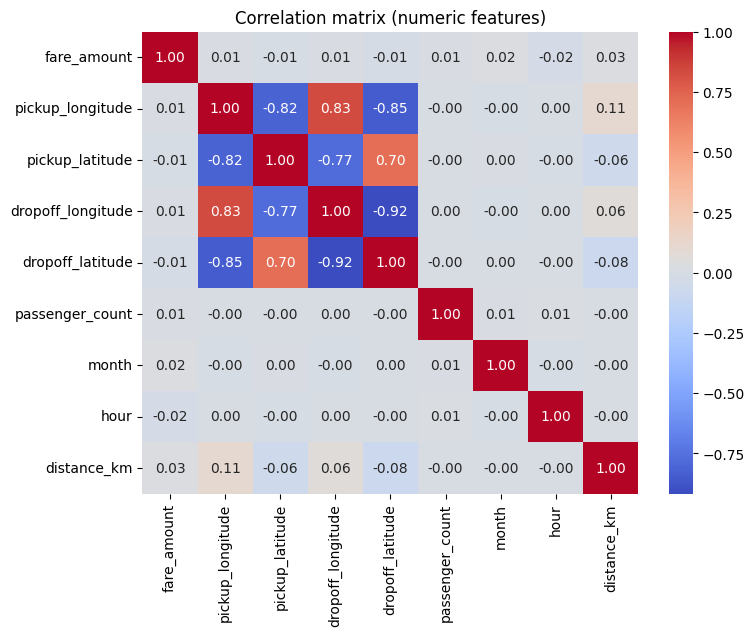

In [ ]:

# Correlation heatmap (using numeric columns)
plt.figure(figsize=(8,6))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (numeric features)')
plt.show()


In [ ]:

# Prepare features and target
# Choose a reasonable set of features
features = []
for c in ['distance_km','passenger_count','hour','month','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    if c in df.columns:
        features.append(c)
print("Using features:", features)

X = df[features].copy()
y = df['fare_amount'].copy()

# Fill any remaining NaNs in X with median
X = X.fillna(X.median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print("Train/Test sizes:", X_train.shape, X_test.shape)


Using features: ['distance_km', 'passenger_count', 'hour', 'month', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
Train/Test sizes: (169999, 8) (30000, 8)


In [ ]:

# Scale numeric features (important for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("Linear Regression — R2: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(r2_lr, rmse_lr, mae_lr))


Linear Regression — R2: 0.0014, RMSE: 10.1510, MAE: 6.0296


In [ ]:

# Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)  # tree-based models don't require scaled features
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest — R2: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(r2_rf, rmse_rf, mae_rf))


Random Forest — R2: 0.6844, RMSE: 5.7064, MAE: 2.2417


In [ ]:

# Comparison table
results = pd.DataFrame({
    'model': ['LinearRegression','RandomForest'],
    'r2': [r2_lr, r2_rf],
    'rmse': [rmse_lr, rmse_rf],
    'mae': [mae_lr, mae_rf]
})
display(results)


,model,r2,rmse,mae
0,LinearRegression,0.001426,10.150997,6.029589
1,RandomForest,0.684446,5.706311,2.241502
